## Adobe-Stock-Forecasting-Deep-Learning Model

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Conv1D, MaxPool1D, GlobalAvgPool1D
from tensorflow.keras.optimizers import RMSprop
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.metrics import mean_absolute_error
tf.random.set_seed(17)

## Pull Adobe market data

In [6]:
#Use yfinance to return market data from 01/01/2017-04/07/2023
# TODO
yf.pdr_override()
# download dataframe
data = pdr.get_data_yahoo("ADBE", start="2017-01-01", end="2023-04-07")
#last 10 rows
data.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-24,370.230011,375.230011,367.720001,374.959991,374.959991,2993400
2023-03-27,376.510010,380.350006,369.679993,373.149994,373.149994,2832200
2023-03-28,373.420013,374.000000,367.820007,373.399994,373.399994,1780800
2023-03-29,376.679993,380.119995,375.559998,379.160004,379.160004,2497600
2023-03-30,381.649994,382.579987,378.079987,381.899994,381.899994,2139000
2023-03-31,382.290009,385.730011,380.260010,385.369995,385.369995,3062300
2023-04-03,380.880005,383.730011,378.149994,380.079987,380.079987,2712600
2023-04-04,382.239990,385.700012,381.049988,385.149994,385.149994,2569800
2023-04-05,384.089996,386.000000,377.260010,382.019989,382.019989,2277200


## Plot column data

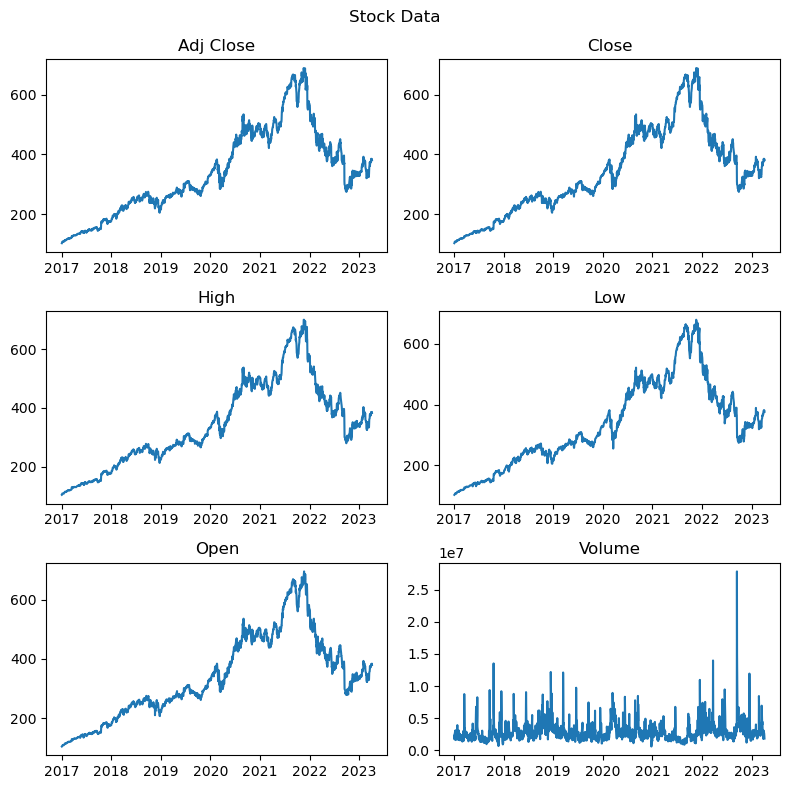

In [7]:
# TODO
# Define subplots
fig, axes = plt.subplots(3,2, figsize=(8, 8))

# Plot the Adj Close column
axes[0, 0].plot(data['Adj Close'])
axes[0, 0].set_title('Adj Close')

# Plot the Close column
axes[0, 1].plot(data['Close'])
axes[0, 1].set_title('Close')

# Plot the High column
axes[1, 0].plot(data['High'])
axes[1, 0].set_title('High')

# Plot the Low column
axes[1, 1].plot(data['Low'])
axes[1, 1].set_title('Low')

# Plot the Open column
axes[2, 0].plot(data['Open'])
axes[2, 0].set_title('Open')

# Plot the Volume column
axes[2, 1].plot(data['Volume'])
axes[2, 1].set_title('Volume')

fig.suptitle('Stock Data')
plt.tight_layout()
plt.show()

## Format Data
Remove Adj Close Column and reduce data values for Neural Network

In [8]:
# TODO
# Sort data by date
data.sort_values(by=['Date'], inplace=True)

# Exclude Adj Close column and scale data
cols = ['Open', 'High', 'Low', 'Close']
data[cols] = data[cols] / 1000
data['Volume'] = data['Volume'] / 1000000000

In [9]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,0.10343,0.10403,0.10281,0.10348,103.480003,0.002277
2017-01-04,0.10374,0.10437,0.10350,0.10414,104.139999,0.001713
2017-01-05,0.10413,0.10602,0.10377,0.10591,105.910004,0.002504
2017-01-06,0.10598,0.10843,0.10525,0.10830,108.300003,0.002626
2017-01-09,0.10796,0.10879,0.10756,0.10857,108.570000,0.002925
2017-01-10,0.10857,0.10879,0.10761,0.10826,108.260002,0.003081
2017-01-11,0.10823,0.10905,0.10800,0.10899,108.989998,0.001784
2017-01-12,0.10799,0.10874,0.10716,0.10859,108.589996,0.001618
2017-01-13,0.10884,0.10890,0.10798,0.10853,108.529999,0.001594


## Split data into training, val, test sets
The target for each sample is the value of the Close column one day after the seventh day of the input sequence. The data will be split as follows:
2017 to 2020 training
2021 for validation
2022 till today for testing

In [10]:
# Create sequences of market data 
sequence_length = 7
delay = 1
batch_size = 16

# Grab data values and targets
data_values = data.values
targets = data_values[sequence_length+delay-1:, 3]

samples = []
for i in range(len(data_values) - sequence_length - delay + 1):
    sample = data_values[i:i+sequence_length, :]
    samples.append(sample)
    
samples = np.array(samples)

# Get the years for each sample
years = data.index[sequence_length+delay-1:].year

# Split data into training, validation, and testing 
train_samples = samples[years < 2021]
train_targets = targets[years < 2021]
val_samples = samples[years == 2021]
val_targets = targets[years == 2021]
test_samples = samples[years >= 2022]
test_targets = targets[years >= 2022]

# Reshape input data
train_samples = train_samples.reshape(train_samples.shape[0], -1)
val_samples = val_samples.reshape(val_samples.shape[0], -1)
test_samples = test_samples.reshape(test_samples.shape[0], -1)

# Create datasets
train_ds = keras.utils.timeseries_dataset_from_array(
    train_samples,
    targets=train_targets,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size)

val_ds = keras.utils.timeseries_dataset_from_array(
    val_samples,
    targets=val_targets,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size)

test_ds = keras.utils.timeseries_dataset_from_array(
    test_samples,
    targets=test_targets,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size)

# print number of batches for each dataset
print("Number of batches in training set:", len(train_ds))
print("Number of batches in validation set:", len(val_ds))
print("Number of batches in test set:", len(test_ds))

2023-04-07 15:39:21.798276: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-07 15:39:21.798347: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-07 15:39:21.798402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eff1027c6ec2): /proc/driver/nvidia/version does not exist


Number of batches in training set: 63
Number of batches in validation set: 16
Number of batches in test set: 20


In [11]:
#Function that plots the actual Close values in the same plot as their corresponding predicted values
def actual_vs_predicted(model, test_ds, diagonal=([0,1], [0,1]), axes=None):
    if axes is None:
        fig, axes = plt.subplots(1,3, figsize=(18, 4))
    else:
        axes = axes.flatten()
    
    actual = np.array([])
    for samples, targets in test_ds:
        actual = np.concatenate([actual, targets])

    pred = model.predict(test_ds).flatten()

    axes[0].scatter(actual, pred)
    axes[0].plot(*diagonal, c="orange", lw=2)
    axes[0].set_title("Actual vs. Predicted")
    
    forecasts = pd.DataFrame({ 'Actual': actual, 'Predicted': pred})
    forecasts.plot(subplots=True, ax=axes[1:])
    axes[1].set_title("Actual Values")
    axes[2].set_title("Predicted Values")


In [12]:
#Function that calculates the MAE
def calculate_mae(model, ds):
    y_pred = model.predict(ds)
    y_true = []
    for x, y in ds:
        y_true.append(y)
    y_true = np.concatenate(y_true)
    mae = mean_absolute_error(y_true, y_pred)
    return mae

## Build and Test RNN model

Epoch 1/10
63/63 [==============================] - 6s 34ms/step - loss: 205.9892 - mae: 8.8449 - val_loss: 1.4695 - val_mae: 0.9188
Epoch 2/10
63/63 [==============================] - 1s 15ms/step - loss: 36.7401 - mae: 3.3245 - val_loss: 201.0011 - val_mae: 14.0170
Epoch 3/10
63/63 [==============================] - 1s 15ms/step - loss: 14.0361 - mae: 2.0018 - val_loss: 0.5804 - val_mae: 0.7036
Epoch 4/10
63/63 [==============================] - 1s 16ms/step - loss: 6.3281 - mae: 1.2521 - val_loss: 5.5064 - val_mae: 2.2974
Epoch 5/10
63/63 [==============================] - 1s 15ms/step - loss: 2.7634 - mae: 0.8957 - val_loss: 3.2284 - val_mae: 1.7241
Epoch 6/10
63/63 [==============================] - 1s 16ms/step - loss: 2.3741 - mae: 0.7816 - val_loss: 6.0921 - val_mae: 2.4411
Epoch 7/10
63/63 [==============================] - 1s 14ms/step - loss: 3.6222 - mae: 0.7901 - val_loss: 6.4208 - val_mae: 2.5024
Epoch 8/10
63/63 [==============================] - 1s 15ms/step - loss: 0.8

array([[<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

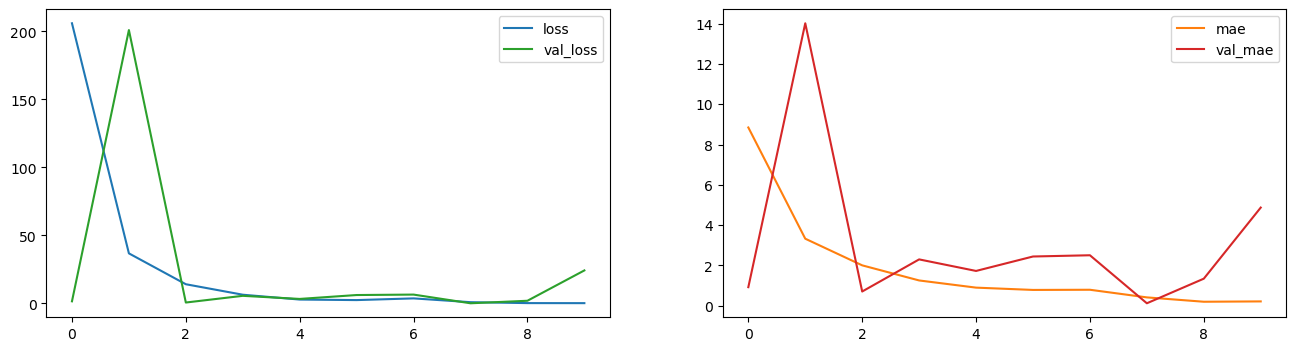

In [13]:
# Define the input shape 
inputs = keras.Input(shape=(None,42))

# Define the model 
x = SimpleRNN(64, activation='relu', return_sequences=True)(inputs)
x = SimpleRNN(64, activation='relu', return_sequences=True)(x)
x = SimpleRNN(64, activation='relu', return_sequences=False)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)

model_rnn = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model_rnn.compile(optimizer=RMSprop(), loss='mse', metrics=['mae'])

# Train the model
history = model_rnn.fit(train_ds, epochs=10, validation_data=val_ds)
model_rnn.summary()

# Plot the learning curves
pd.DataFrame(history.history).plot(subplots=[('loss', 'val_loss'), ('mae', 'val_mae')], layout=(1,2), figsize=(16,4))

## Update RNN model with LSTM layers

Epoch 1/10
63/63 [==============================] - 9s 42ms/step - loss: 1.0709 - mae: 0.5599 - val_loss: 0.0153 - val_mae: 0.0963
Epoch 2/10
63/63 [==============================] - 2s 26ms/step - loss: 0.0186 - mae: 0.0812 - val_loss: 2.9560 - val_mae: 1.6477
Epoch 3/10
63/63 [==============================] - 2s 28ms/step - loss: 0.0411 - mae: 0.0987 - val_loss: 0.0056 - val_mae: 0.0621
Epoch 4/10
63/63 [==============================] - 2s 26ms/step - loss: 0.0058 - mae: 0.0445 - val_loss: 1.4515 - val_mae: 1.1284
Epoch 5/10
63/63 [==============================] - 2s 26ms/step - loss: 0.0042 - mae: 0.0488 - val_loss: 0.0043 - val_mae: 0.0550
Epoch 6/10
63/63 [==============================] - 2s 28ms/step - loss: 0.0039 - mae: 0.0482 - val_loss: 0.0046 - val_mae: 0.0577
Epoch 7/10
63/63 [==============================] - 2s 27ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0029 - val_mae: 0.0432
Epoch 8/10
63/63 [==============================] - 2s 27ms/step - loss: 0.2091 - m

array([[<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

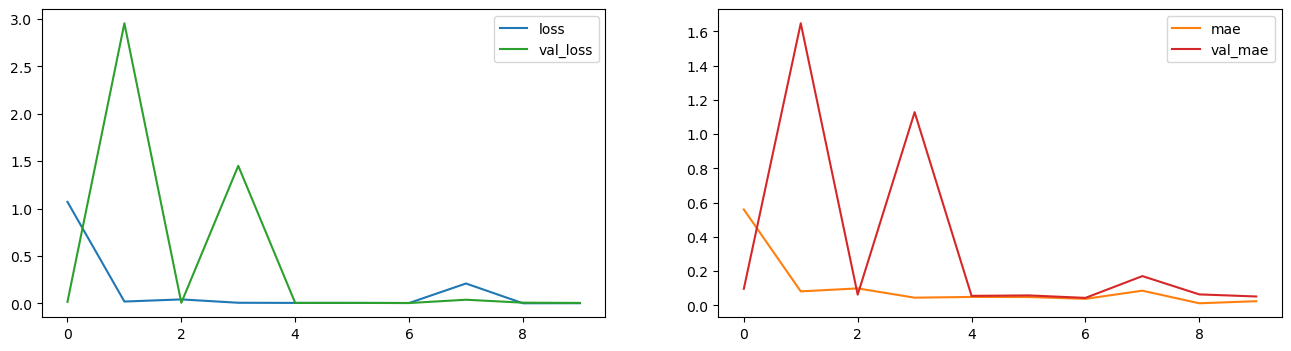

In [14]:
#Define the input shape 
inputs = keras.Input(shape=(None, 42))

#Define the model
x = LSTM(64, activation='relu', return_sequences=True)(inputs)
x = LSTM(64, activation='relu', return_sequences=True)(x)
x = LSTM(64, activation='relu', return_sequences=False)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)

model_lstm = keras.Model(inputs=inputs, outputs=outputs)

#Compile the model 
model_lstm.compile(optimizer=RMSprop(), loss='mse', metrics=['mae'])
hist = model_lstm.fit(train_ds, epochs=10, validation_data=val_ds)

model_lstm.summary()

#Plot the learning curves
pd.DataFrame(hist.history).plot(subplots=[['loss', 'val_loss'], ['mae', 'val_mae']], layout=(1, 2), figsize=(16, 4))

## Update RNN with GRU layers

Epoch 1/10
63/63 [==============================] - 7s 34ms/step - loss: 3.1151 - mae: 1.4659 - val_loss: 0.6640 - val_mae: 0.7931
Epoch 2/10
63/63 [==============================] - 1s 21ms/step - loss: 1.2265 - mae: 0.6576 - val_loss: 0.8628 - val_mae: 0.9155
Epoch 3/10
63/63 [==============================] - 1s 19ms/step - loss: 0.9235 - mae: 0.5394 - val_loss: 0.1614 - val_mae: 0.3588
Epoch 4/10
63/63 [==============================] - 1s 19ms/step - loss: 0.4091 - mae: 0.3749 - val_loss: 0.3114 - val_mae: 0.5501
Epoch 5/10
63/63 [==============================] - 1s 20ms/step - loss: 0.3142 - mae: 0.3395 - val_loss: 0.0354 - val_mae: 0.1352
Epoch 6/10
63/63 [==============================] - 1s 21ms/step - loss: 0.1746 - mae: 0.2613 - val_loss: 0.0138 - val_mae: 0.0994
Epoch 7/10
63/63 [==============================] - 1s 20ms/step - loss: 0.0929 - mae: 0.1903 - val_loss: 0.0572 - val_mae: 0.2334
Epoch 8/10
63/63 [==============================] - 1s 21ms/step - loss: 0.0825 - m

array([[<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

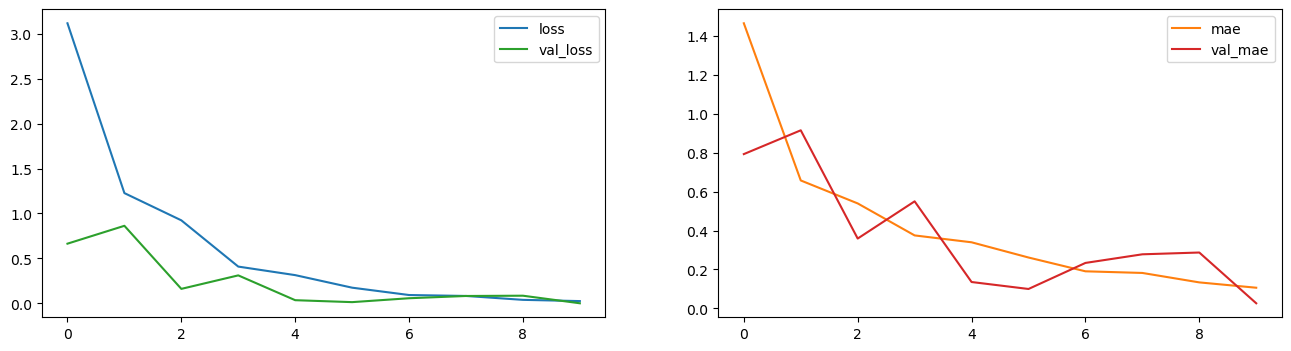

In [16]:
# Define the input shape 
inputs = keras.Input(shape=(None, 42))

# Define the model 
x = GRU(64, activation='relu', return_sequences=True)(inputs)
x = GRU(64, activation='relu', return_sequences=False)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)

model_gru = keras.Model(inputs=inputs, outputs=outputs)
outputs = Dense(1)(x)

# Create the model
model_gru = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model 
model_gru.compile(optimizer=RMSprop(), loss='mse', metrics=['mae'])
hist = model_gru.fit(train_ds, epochs=10, validation_data=val_ds)
model_gru.summary()

pd.DataFrame(hist.history).plot(subplots=[('loss', 'val_loss'), ('mae', 'val_mae')], layout=(1,2), figsize=(16,4))

## Try a 1D CNN Model

Epoch 1/10
63/63 [==============================] - 3s 16ms/step - loss: 7.5982 - mae: 1.7576 - val_loss: 13.6938 - val_mae: 3.6593
Epoch 2/10
63/63 [==============================] - 0s 7ms/step - loss: 0.5779 - mae: 0.5317 - val_loss: 1.4643 - val_mae: 1.1959
Epoch 3/10
63/63 [==============================] - 0s 8ms/step - loss: 0.4002 - mae: 0.3231 - val_loss: 0.0023 - val_mae: 0.0311
Epoch 4/10
63/63 [==============================] - 0s 7ms/step - loss: 0.1459 - mae: 0.1611 - val_loss: 0.3615 - val_mae: 0.5954
Epoch 5/10
63/63 [==============================] - 0s 7ms/step - loss: 0.0694 - mae: 0.1609 - val_loss: 0.0057 - val_mae: 0.0529
Epoch 6/10
63/63 [==============================] - 0s 8ms/step - loss: 0.0120 - mae: 0.0480 - val_loss: 0.0290 - val_mae: 0.1599
Epoch 7/10
63/63 [==============================] - 0s 8ms/step - loss: 0.0094 - mae: 0.0579 - val_loss: 0.0257 - val_mae: 0.1583
Epoch 8/10
63/63 [==============================] - 0s 7ms/step - loss: 0.0068 - mae: 0.

array([[<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

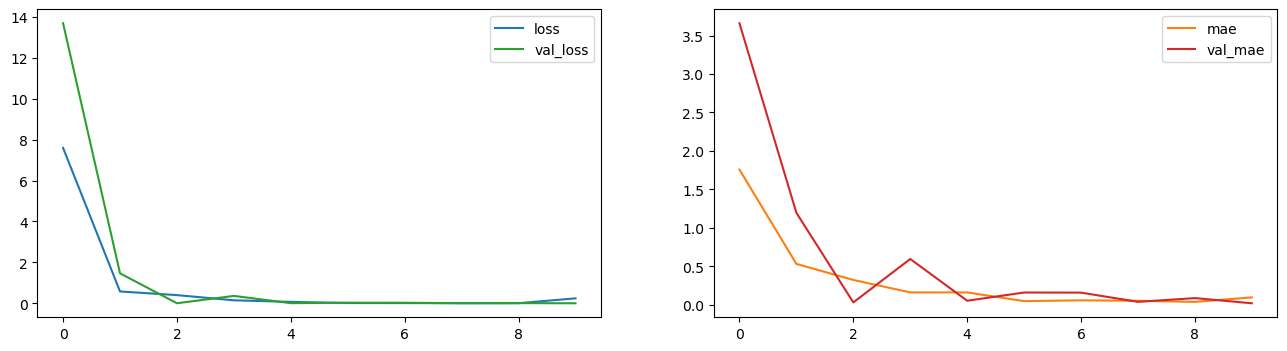

In [17]:
# Define the model 
inputs = keras.Input(shape=(128, 42))
x = keras.layers.Conv1D(16, 4, activation="relu", padding="same")(inputs)
x = keras.layers.Conv1D(16, 4, activation="relu", padding="same")(x)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Conv1D(32, 2, activation="relu", padding="same")(x)
x = keras.layers.Conv1D(32, 2, activation="relu", padding="same")(x)
x = keras.layers.GlobalAveragePooling1D()(x)
outputs = keras.layers.Dense(1)(x)

model_1D = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model 
model_1D.compile(optimizer=RMSprop(), loss='mse', metrics=['mae'])

# Train the model 
hist = model_1D.fit(train_ds, epochs=10, validation_data=val_ds)
pd.DataFrame(hist.history).plot(subplots=[('loss', 'val_loss'), ('mae', 'val_mae')], layout=(1,2), figsize=(16,4))

## Plot all models

20/20 [==============================] - 0s 5ms/step


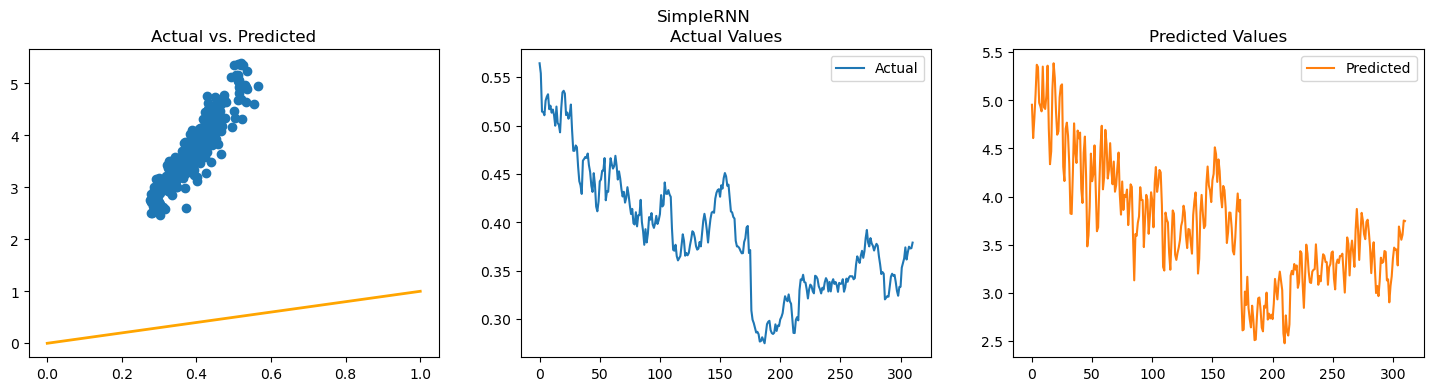

20/20 [==============================] - 0s 8ms/step


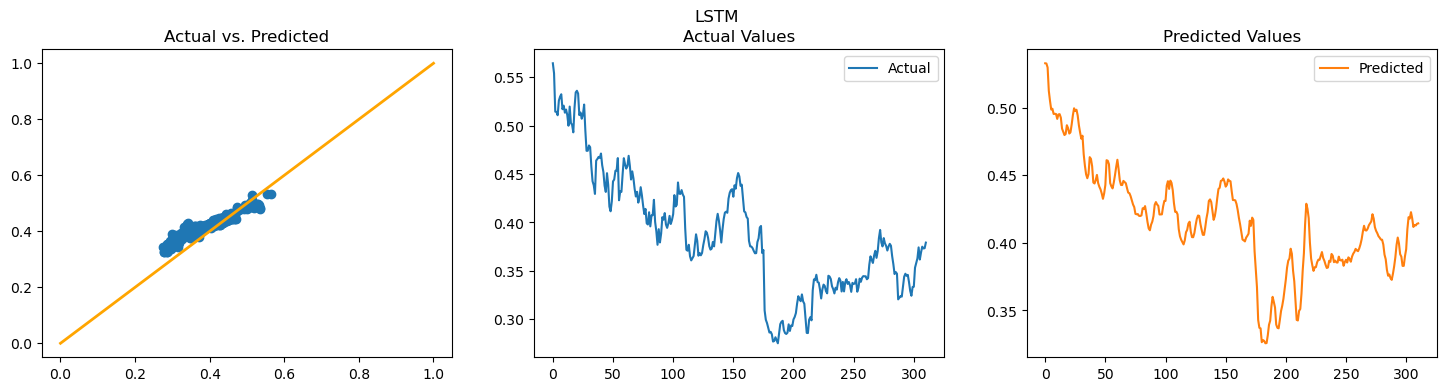

20/20 [==============================] - 0s 7ms/step


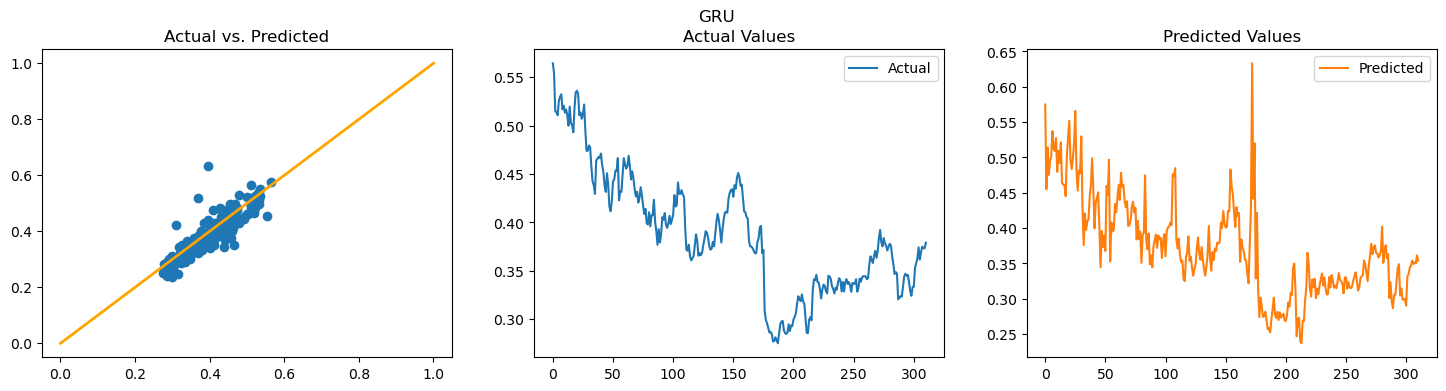

20/20 [==============================] - 0s 2ms/step


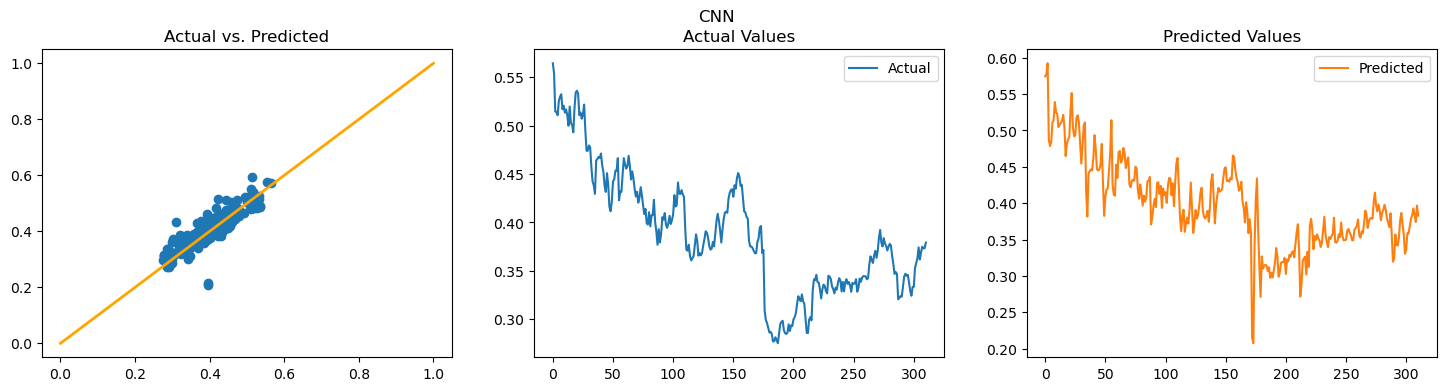

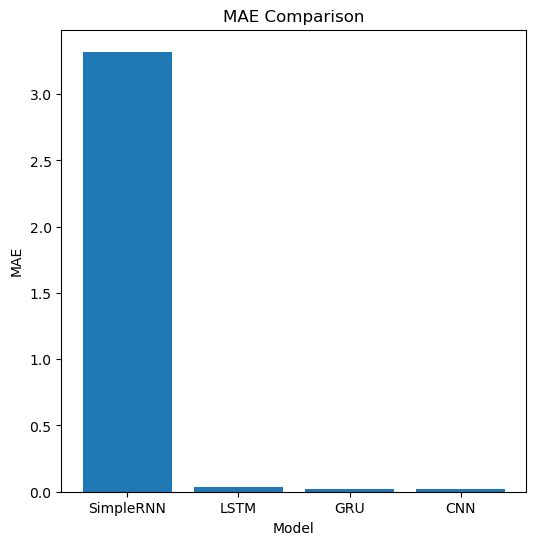

In [18]:
model_names = ['SimpleRNN', 'LSTM', 'GRU', 'CNN']
actual_predicted = []
maes = []
for i, model in enumerate([model_rnn, model_lstm, model_gru, model_1D]):
    # Get the actual vs predicted values
    actual_predicted.append(model.evaluate(test_ds, verbose=0))
    # Get the MAE
    mae = calculate_mae(model, test_ds)
    maes.append(mae)
    # Plot the actual vs predicted values
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    actual_vs_predicted(model, test_ds, diagonal=([0, 1], [0, 1]), axes=axes)
    plt.suptitle(model_names[i])
    plt.show()

# Create a bar plot 
plt.figure(figsize=(6, 6))
plt.bar(model_names, maes)
plt.title('MAE Comparison')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.show()

The model with the smallest MAE and performed the best was the CNN model with the RNN model using GRU and LSTM layers a close second. The model that performed the poorest and had the highest MAE score was the Simple RNN. The CNN and GRU model were slightly optimistic by predicting values slightly higher than the actual values and the simple rnn and LSTM were slightly pessimistic and predicted values lower than the actual values. Overall one of those three models could be an effective model for predicting next day stock prices for ADOBE.